In [1]:
# the purpose of this notebook is to run a DTL and TPL endmember of the model to ss
# this can be accomplished via attrtion
# high rate of attrition = DTL
# low rate of attrition = TPL

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# now see if I can get a copied and pasted version of the two lithology model working
# and then tweak things, OAT, to see what the issue is with loooooong runtimes on this single lith model

# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)

# set up runoff rate
r = np.zeros(len(x))
r[:] = 0.3

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.00004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.00014
atr_factor = 0.00004

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.0001
k_sed = np.zeros(len(x))
k_sed[25:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 3000000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.05 * 0.2 * dx * dx / (c*q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, cum_time)

In [5]:
# create the input experiment
TL_ss = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r]

# and run away with it!
(slope_TL,
 sed_flux_TL,
 e_factor_TL,
 topography_TL,
 bedrock_elevation_TL,
 igneous_plucking_rate_TL,
 sedimentary_plucking_rate_TL,
 igneous_abrasion_rate_TL,
 sedimentary_abrasion_rate_TL,
 bedrock_erosion_rate_TL,
 attrition_rate_TL,
 sedimentation_rate_TL,
 sediment_thickness_TL,
 total_erosion_rate_TL,
 cum_time_TL) = two_lith_one_sed(*TL_ss)

1010101.3467490787


In [6]:
# okay, that worked!
# check to see if we're at steady state
print(bedrock_erosion_rate_TL)

[0.00099998 0.00099999 0.00099999 0.00099999 0.00099999 0.00099999
 0.00099999 0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001      0.001      0.001
 0.

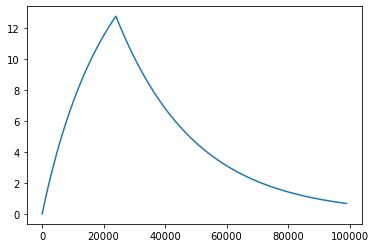

In [7]:
# check if we're close to TPL
plt.plot(x, sed_flux_TL)

In [8]:
atr_TPL = 0.0000004
atr_DTL = 0.01

In [9]:
# SET UP GRID ARRAYS
dx_2 = 1000
x_2 = np.arange(0, 100000, dx_2)

# set up runoff rate
r_2 = np.zeros(len(x_2))
r_2[:] = 0.3

# set up references to topography
Hstar_2 = 0.1
H_2 = Hstar_2 + np.zeros(len(x_2))
etab_2 = -H_2
eta_2 = etab_2 + H_2

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_2 = np.zeros(len(x_2))
beta_ig_2[:25] = 0.00004
beta_sed_2 = np.zeros(len(x_2))
beta_sed_2[25:] = 0.00014
# atr_factor

# erodibility values
k_ig_2 = np.zeros(len(x_2))
k_ig_2[:25] = 0.0001
k_sed_2 = np.zeros(len(x_2))
k_sed_2[25:] = 0.001

In [10]:
# create the input experiment
TPL = [x_2, dx_2, Hstar_2, H_2, etab_2, eta_2, beta_ig_2, beta_sed_2, atr_TPL, k_ig_2, k_sed_2, r_2]

# and run away with it!
(slope_TPL,
 sed_flux_TPL,
 e_factor_TPL,
 topography_TPL,
 bedrock_elevation_TPL,
 igneous_plucking_rate_TPL,
 sedimentary_plucking_rate_TPL,
 igneous_abrasion_rate_TPL,
 sedimentary_abrasion_rate_TPL,
 bedrock_erosion_rate_TPL,
 attrition_rate_TPL,
 sedimentation_rate_TPL,
 sediment_thickness_TPL,
 total_erosion_rate_TPL,
 cum_time_TPL) = two_lith_one_sed(*TPL)

1010101.3467490787


In [11]:
# check for ss position
print(bedrock_erosion_rate_TPL)

[0.00099582 0.00099673 0.00099712 0.00099736 0.00099754 0.00099769
 0.00099781 0.00099791 0.00099801 0.00099809 0.00099817 0.00099824
 0.00099831 0.00099837 0.00099843 0.00099849 0.00099854 0.0009986
 0.00099864 0.00099869 0.00099874 0.00099878 0.00099882 0.00099886
 0.0009989  0.00099894 0.00099897 0.000999   0.00099903 0.00099905
 0.00099908 0.00099911 0.00099913 0.00099915 0.00099918 0.0009992
 0.00099922 0.00099924 0.00099926 0.00099928 0.0009993  0.00099932
 0.00099934 0.00099936 0.00099938 0.0009994  0.00099941 0.00099943
 0.00099945 0.00099946 0.00099948 0.00099949 0.00099951 0.00099952
 0.00099954 0.00099955 0.00099957 0.00099958 0.00099959 0.00099961
 0.00099962 0.00099963 0.00099964 0.00099966 0.00099967 0.00099968
 0.00099969 0.0009997  0.00099972 0.00099973 0.00099974 0.00099975
 0.00099976 0.00099977 0.00099978 0.00099979 0.0009998  0.00099981
 0.00099982 0.00099983 0.00099984 0.00099985 0.00099986 0.00099987
 0.00099988 0.00099989 0.00099989 0.0009999  0.00099991 0.000999

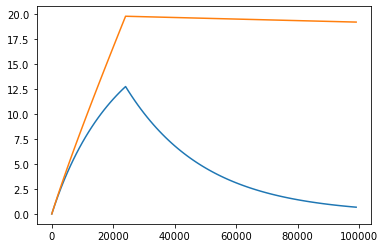

In [12]:
# check if we're close to TPL
plt.plot(x, sed_flux_TL)
plt.plot(x_2, sed_flux_TPL)

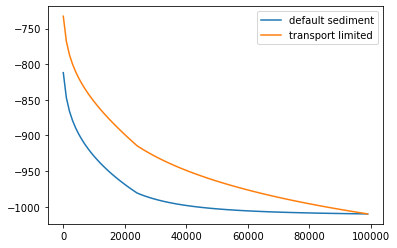

In [13]:
# compare default and TPL runs
plt.plot(x, topography_TL, label = 'default sediment')
plt.plot(x_2, topography_TPL, label = 'transport limited')
plt.legend()

In [14]:
# SET UP GRID ARRAYS
dx_3 = 1000
x_3 = np.arange(0, 100000, dx_3)

# set up runoff rate
r_3 = np.zeros(len(x_3))
r_3[:] = 0.3

# set up references to topography
Hstar_3 = 0.1
H_3 = Hstar_3 + np.zeros(len(x_3))
etab_3 = -H_3
eta_3 = etab_3 + H_3

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_3 = np.zeros(len(x_3))
beta_ig_3[:25] = 0.00004
beta_sed_3 = np.zeros(len(x_3))
beta_sed_3[25:] = 0.00014
# atr_factor

# erodibility values
k_ig_3 = np.zeros(len(x_3))
k_ig_3[:25] = 0.0001
k_sed_3 = np.zeros(len(x_3))
k_sed_3[25:] = 0.001

In [15]:
# create the input experiment
DTL = [x_3, dx_3, Hstar_3, H_3, etab_3, eta_3, beta_ig_3, beta_sed_3, atr_DTL, k_ig_3, k_sed_3, r_3]

# and run away with it!
(slope_DTL,
 sed_flux_DTL,
 e_factor_DTL,
 topography_DTL,
 bedrock_elevation_DTL,
 igneous_plucking_rate_DTL,
 sedimentary_plucking_rate_DTL,
 igneous_abrasion_rate_DTL,
 sedimentary_abrasion_rate_DTL,
 bedrock_erosion_rate_DTL,
 attrition_rate_DTL,
 sedimentation_rate_DTL,
 sediment_thickness_DTL,
 total_erosion_rate_DTL,
 cum_time_DTL) = two_lith_one_sed(*DTL)

1010101.3467490787


In [16]:
# check for ss condition
print(bedrock_erosion_rate_DTL)

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.   ]


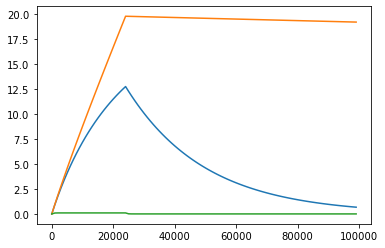

In [18]:
# check if we're close to TPL
plt.plot(x, sed_flux_TL)
plt.plot(x_2, sed_flux_TPL)
plt.plot(x_3, sed_flux_DTL)

In [ ]:
lowest_elev = topography_TPL[-1]

In [ ]:
highest_elev = topography_TPL[0] - lowest_elev

In [ ]:
print(highest_elev)

In [ ]:
# okay compare stuff
# plt.plot(x, topography_TL, label = 'default sediment')
plt.figure(figsize = (10, 4))

plt.plot(x_2/100000, (topography_TPL-lowest_elev)/278, label = 'transport limited', linestyle = '.', linewidth = 3, color = 'mediumseagreen')
plt.plot(x_3/100000, (topography_DTL-lowest_elev)/278, label = 'detachment limited', linestyle = '.', linewidth = 3, color = 'teal')
plt.xlabel('Distance', fontsize = 14)
plt.ylabel('Elevation', fontsize = 14)
plt.title('Endmember Model Behaviors', fontsize = 16)
plt.legend(fontsize = 12)

# plt.savefig('/Users/vanessa/Desktop/summer 2022/fig4.png')
plt.show()

In [ ]:
# now let's see if we can generate similar behavior by tweaking H*
# if H* is sufficiently large, bed will never be entirely covered, 
# and thus behavior will be TPL

In [ ]:
# SET UP GRID ARRAYS
dx_4 = 1000
x_4 = np.arange(0, 100000, dx_4)

# set up runoff rate
r_4 = np.zeros(len(x_4))
r_4[:] = 0.3

# set up references to topography
Hstar_4 = 1
H_4 = Hstar_4 + np.zeros(len(x_4))
etab_4 = -H_4
eta_4 = etab_4 + H_4

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_4 = np.zeros(len(x_4))
beta_ig_4[:25] = 0.00004
beta_sed_4 = np.zeros(len(x_4))
beta_sed_4[25:] = 0.00014
# atr_factor

# erodibility values
k_ig_4 = np.zeros(len(x_4))
k_ig_4[:25] = 0.0001
k_sed_4 = np.zeros(len(x_4))
k_sed_4[25:] = 0.001

In [ ]:
# create the input experiment
high_Hstar = [x_4, dx_4, Hstar_4, H_4, etab_4, eta_4, beta_ig_4, beta_sed_4, atr_factor, k_ig_4, k_sed_4, r_4]

# and run away with it!
(slope_high_Hstar,
 sed_flux_high_Hstar,
 e_factor_high_Hstar,
 topography_high_Hstar,
 bedrock_elevation_high_Hstar,
 igneous_plucking_rate_high_Hstar,
 sedimentary_plucking_rate_high_Hstar,
 igneous_abrasion_rate_high_Hstar,
 sedimentary_abrasion_rate_high_Hstar,
 bedrock_erosion_rate_high_Hstar,
 attrition_rate_high_Hstar,
 sedimentation_rate_high_Hstar,
 sediment_thickness_high_Hstar,
 total_erosion_rate_high_Hstar,
 cum_time_high_Hstar) = two_lith_one_sed(*high_Hstar)

In [ ]:
# check for ss condition
print(bedrock_erosion_rate_high_Hstar)

In [ ]:
# now see if high Hstar gets us closer to DTL topo
# plt.plot(x, topography_TL)
# plt.plot(x, topography_DTL)
plt.plot(x, topography_high_Hstar)

In [ ]:
plt.plot(x_4, sed_flux_high_Hstar)